# Прикладные задачи анализа данных

## Домашнее задание 4

В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер.

In [2]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [4]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [5]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (1 балл).** Реализуйте метрику $MAP@k$.

In [6]:
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    def apk(relevant, predicted, k):
        if len(predicted) > k:
            predicted = predicted[:k]

        score = 0.0
        num_hits = 0.0

        for i, p in enumerate(predicted):
            if p in relevant and p not in predicted[:i]:
                num_hits += 1.0
                score += num_hits / (i + 1.0)

        return score / min(len(relevant), k)

    return np.mean([apk(a, p, k) for a, p in zip(relevant, predicted)])

In [7]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [8]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [9]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [10]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [11]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [12]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [13]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [14]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [15]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (1 балл).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [16]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))
        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.0

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]
        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        for user_id in range(self.n_users):
            user_recommendations = self.recommend(user_id)
            test_preds.append(user_recommendations)

        test_preds = np.array(test_preds)
        test_preds = self.remove_train_items(test_preds, k)
        return test_preds[test_users]


## Часть 1. Коллаборативная фильтрация (User2User)

 Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.1 (1 балл).** Реализуйте функцию подсчета корреляции Пирсона.

**Задание 3.2 (1 балл).** Реализуйте функцию подсчета меры Жаккара.

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [18]:

def pearson(ratings: np.array, user_vector: np.array) -> np.array:
    mean_user_vector = np.mean(user_vector)
    centered_user_vector = user_vector - mean_user_vector

    mean_ratings = np.mean(ratings, axis=1, keepdims=True)
    centered_ratings = ratings - mean_ratings

    numerator = np.sum(centered_ratings * centered_user_vector, axis=1)
    denominator = np.sqrt(np.sum(centered_ratings ** 2, axis=1)) * np.sqrt(np.sum(centered_user_vector ** 2))

    denominator[denominator == 0] = 1

    pearson_correlation = numerator / denominator

    return pearson_correlation

def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    intersection = np.sum((ratings == 1) & (user_vector == 1), axis=1)
    union = np.sum((ratings == 1) | (user_vector == 1), axis=1)

    union[union == 0] = 1

    jaccard_similarity = intersection / union

    return jaccard_similarity




In [19]:

ratings = np.array([
    [1, 1, 0, 0, 1],
    [0, 1, 1, 0, 1],
    [1, 0, 0, 1, 0],
    [1, 1, 1, 0, 0]
])

user_vector = np.array([1, 1, 0, 0, 1])

pearson_similarities = pearson(ratings, user_vector)
print("Корреляция Пирсона:", pearson_similarities)

jaccard_similarities = jaccard(ratings, user_vector)
print("Мера Жаккара:", jaccard_similarities)


Корреляция Пирсона: [ 1.          0.16666667 -0.16666667  0.16666667]
Мера Жаккара: [1.   0.5  0.25 0.5 ]


**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


In [21]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)
        assert similarity_func in [pearson, jaccard]
        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        Вычисляет схожесть между пользователем и всеми остальными пользователями.

        :param user_vector: np.array - вектор оценок целевого пользователя
        :return: np.array - вектор схожести с каждым пользователем
        """
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        """
        Возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.

        :param uid: int - идентификатор пользователя
        :return: list - список рекомендованных треков
        """
        user_vector = self.R[uid]
        similarities = self.similarity(user_vector)


        similarities[uid] = 0


        neighbors = similarities > self.alpha
        if np.sum(neighbors) == 0:
            return np.argsort(user_vector)[::-1].tolist()

        weighted_ratings = np.dot(similarities[neighbors], self.R[neighbors])
        normalizer = np.sum(np.abs(similarities[neighbors]))

        if normalizer == 0:
            normalizer = 1

        predicted_ratings = weighted_ratings / normalizer


        predicted_ratings[user_vector > 0] = -np.inf

        return np.argsort(predicted_ratings)[::-1].tolist()


ratings = pd.read_csv('music_dataset.csv')
tracks_info = pd.read_csv('tracks_info.csv')


train_ratings, test_ratings = train_test_split(ratings)


uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['userId'] = uencoder.transform(train_ratings['userId'].tolist())
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['userId'] = uencoder.transform(test_ratings['userId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())


test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

user2user_model = User2User(train_ratings, similarity_func=pearson)


recommendations = user2user_model.recommend(0)
print("Рекомендации для пользователя 0:", recommendations)


  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Рекомендации для пользователя 0: [9693, 10798, 5499, 24260, 6067, 6376, 189, 11950, 15419, 2755, 13892, 1073, 15305, 2813, 8394, 38044, 4551, 3189, 724, 1306, 14854, 6719, 4985, 3264, 9691, 901, 13029, 7533, 30300, 1666, 2800, 21410, 9681, 4507, 2550, 1081, 2412, 780, 39685, 56031, 6814, 2999, 12047, 5949, 1370, 3431, 878, 21591, 1131, 9492, 7258, 1354, 6135, 1275, 3235, 46726, 3106, 5563, 8187, 954, 23, 17926, 7664, 8057, 419, 2815, 27891, 3211, 24158, 2757, 754, 886, 6436, 27345, 1021, 47569, 29050, 97, 19820, 3191, 3217, 757, 2194, 22364, 445, 2628, 5440, 1624, 2799, 4654, 5437, 4074, 6718, 2764, 418, 14738, 15636, 19489, 630, 7401, 1033, 2941, 2820, 1669, 1074, 785, 26580, 7637, 7286, 6119, 755, 43399, 26784, 11780, 6448, 8271, 34616, 952, 1022, 22073, 177, 45517, 23429, 53102, 94, 27470, 42703, 31699, 46532, 39189, 23961, 36911, 6711, 29262, 15518, 21673, 39680, 14763, 14587, 3709, 7535, 13253, 49118, 10367, 24500, 33508, 13358, 6441, 58937, 4578, 2537, 3562, 41911, 30855, 32116, 

**Задание 5 (1 балл).** Постройте графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравните их между собой, а также с предсказаниями случайного алгоритма и сделайте выводы.

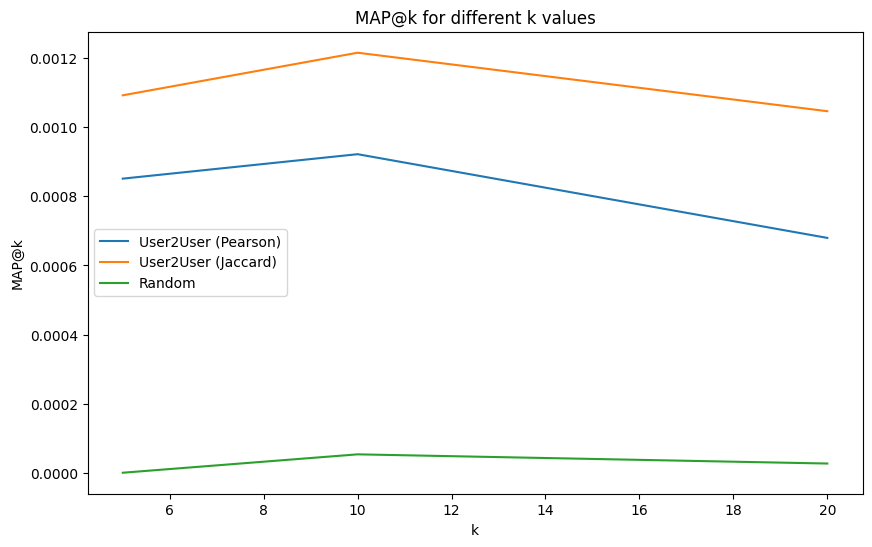

In [23]:
def random_recommendations(n_users, n_items, k):
    return [np.random.choice(n_items, k, replace=False).tolist() for _ in range(n_users)]

n_users = len(np.unique(train_ratings['userId']))
n_items = len(np.unique(train_ratings['trackId']))


k_values = [5, 10, 20]

user2user_model_pearson = User2User(train_ratings, similarity_func=pearson)
user2user_model_jaccard = User2User(train_ratings, similarity_func=jaccard)


def evaluate_model(model, k_values):
    mapk_scores = []
    for k in k_values:
        test_predictions = model.get_test_recommendations(k)
        mapk_score = mapk(test_relevant, test_predictions, k)
        mapk_scores.append(mapk_score)
    return mapk_scores

mapk_pearson = evaluate_model(user2user_model_pearson, k_values)
mapk_jaccard = evaluate_model(user2user_model_jaccard, k_values)


random_preds = random_recommendations(len(test_users), n_items, max(k_values))
mapk_random = [mapk(test_relevant, random_preds, k) for k in k_values]


plt.figure(figsize=(10, 6))
plt.plot(k_values, mapk_pearson, label='User2User (Pearson)')
plt.plot(k_values, mapk_jaccard, label='User2User (Jaccard)')
plt.plot(k_values, mapk_random, label='Random')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.title('MAP@k for different k values')
plt.legend()
plt.show()


### Выводы

1. **Метод User2User с мерой Жаккара** показывает лучшие результаты при всех значениях \(k\), что указывает на то, что данная функция схожести лучше подходит по сравнению с корреляцией Пирсона
2. **Метод User2User с корреляцией Пирсона** показывает стабильные результаты, но они ниже, чем у метода с мерой Жаккара
3. **Случайные рекомендации** показывают значительно худшие результаты по сравнению с методами User2User, что подтверждает эффективность
4. **Зависимость от \(k\)**: Качество предсказаний (MAP@k) для методов User2User сначала увеличивается, а затем несколько снижается с увеличением \(k\). Это ожидаемо, так как предсказание большего числа элементов увеличивает сложность задачи и вероятность ошибки.
5. **Лучший метод**: Метод User2User с мерой Жаккара является наиболее подходящим, так как он демонстрирует лучшие результаты при всех значениях \(k\).


**Задание 6 (1.5 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Time taken by User2User (Pearson) with sparse matrix: 522.8370027542114 seconds
Time taken by User2User (Jaccard) with sparse matrix: 414.24456334114075 seconds


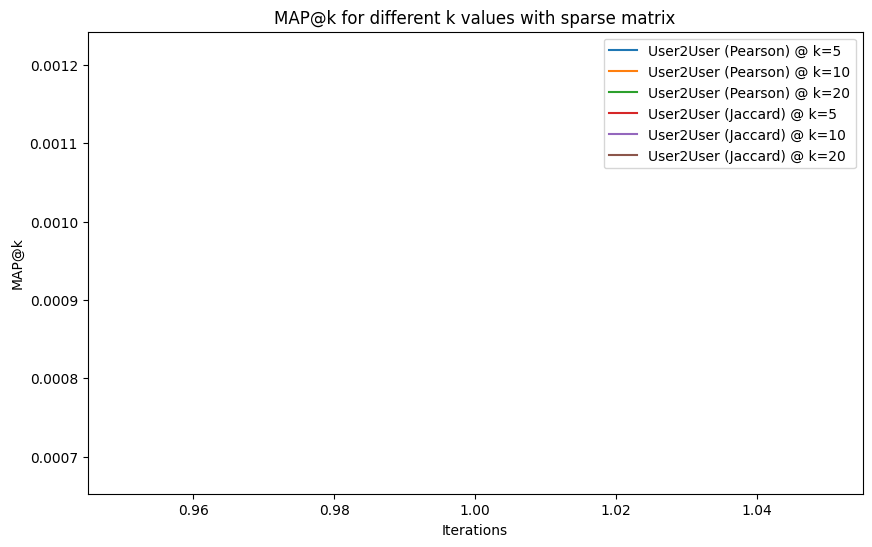

In [29]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs
import time

ratings = pd.read_csv('music_dataset.csv')
tracks_info = pd.read_csv('tracks_info.csv')


def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50


    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()


    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

train_ratings, test_ratings = train_test_split(ratings)




In [33]:

def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['userId'] = uencoder.transform(train_ratings['userId'].tolist())
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['userId'] = uencoder.transform(test_ratings['userId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())



In [34]:

def create_sparse_matrix(ratings, n_users, n_items):
    rows = ratings['userId']
    cols = ratings['trackId']
    data = np.ones(len(ratings))
    return scs.csr_matrix((data, (rows, cols)), shape=(n_users, n_items))

n_users = len(uencoder.classes_)
n_items = len(iencoder.classes_)
R_sparse = create_sparse_matrix(train_ratings, n_users, n_items)


def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    def apk(relevant, predicted, k):
        if len(predicted) > k:
            predicted = predicted[:k]

        score = 0.0
        num_hits = 0.0

        for i, p in enumerate(predicted):
            if p in relevant and p not in predicted[:i]:
                num_hits += 1.0
                score += num_hits / (i + 1.0)

        return score / min(len(relevant), k)

    return np.mean([apk(a, p, k) for a, p in zip(relevant, predicted)])




In [35]:

test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)


class BaseModel:
    def __init__(self, R_sparse):
        self.R = R_sparse
        self.n_users, self.n_items = self.R.shape

    def recommend(self, uid: int):
        raise NotImplementedError

    def remove_train_items(self, preds: np.array, k: int):
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id in range(len(preds)):
            train_items = self.R[user_id].indices
            new_preds[user_id] = [item for item in preds[user_id] if item not in train_items][:k]
        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        for user_id in range(self.n_users):
            user_recommendations = self.recommend(user_id)
            test_preds.append(user_recommendations)

        test_preds = np.array(test_preds)
        test_preds = self.remove_train_items(test_preds, k)
        return test_preds[test_users]



In [36]:

def pearson(ratings: np.array, user_vector: np.array) -> np.array:
    mean_user_vector = np.mean(user_vector)
    centered_user_vector = user_vector - mean_user_vector

    mean_ratings = np.mean(ratings, axis=1, keepdims=True)
    centered_ratings = ratings - mean_ratings

    numerator = np.sum(centered_ratings * centered_user_vector, axis=1)
    denominator = np.sqrt(np.sum(centered_ratings ** 2, axis=1)) * np.sqrt(np.sum(centered_user_vector ** 2))

    denominator[denominator == 0] = 1

    pearson_correlation = numerator / denominator

    return pearson_correlation

def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    intersection = np.sum((ratings == 1) & (user_vector == 1), axis=1)
    union = np.sum((ratings == 1) | (user_vector == 1), axis=1)

    union[union == 0] = 1

    jaccard_similarity = intersection / union

    return jaccard_similarity



In [37]:

class User2User(BaseModel):
    def __init__(self, R_sparse, similarity_func):
        super().__init__(R_sparse)
        assert similarity_func in [pearson, jaccard]
        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector):
        return self.similarity_func(self.R.toarray(), user_vector.toarray().flatten())

    def recommend(self, uid: int):
        user_vector = self.R[uid]
        similarities = self.similarity(user_vector)

        similarities[uid] = 0


        neighbors = similarities > self.alpha
        if np.sum(neighbors) == 0:
            return np.argsort(user_vector.toarray().flatten())[::-1].tolist()

        weighted_ratings = np.dot(similarities[neighbors], self.R[neighbors].toarray())
        normalizer = np.sum(np.abs(similarities[neighbors]))

        if normalizer == 0:
            normalizer = 1

        predicted_ratings = weighted_ratings / normalizer

        predicted_ratings[user_vector.indices] = -np.inf

        return np.argsort(predicted_ratings)[::-1]



In [ ]:

def evaluate_model(model, k_values):
    mapk_scores = {k: [] for k in k_values}
    for k in k_values:
        test_predictions = model.get_test_recommendations(k)
        mapk_score = mapk(test_relevant, test_predictions, k)
        mapk_scores[k].append(mapk_score)
    return mapk_scores


def measure_time(model, k_values):
    start_time = time.time()
    evaluate_model(model, k_values)
    end_time = time.time()
    return end_time - start_time

k_values = [5, 10, 20]

user2user_model_pearson_sparse = User2User(R_sparse, similarity_func=pearson)
user2user_model_jaccard_sparse = User2User(R_sparse, similarity_func=jaccard)

time_sparse_pearson = measure_time(user2user_model_pearson_sparse, k_values)
time_sparse_jaccard = measure_time(user2user_model_jaccard_sparse, k_values)

print(f"Time taken by User2User (Pearson) with sparse matrix: {time_sparse_pearson} seconds")
print(f"Time taken by User2User (Jaccard) with sparse matrix: {time_sparse_jaccard} seconds")


def plot_mapk_scores(mapk_scores, k_values, label):
    for k in k_values:
        plt.plot(range(1, len(mapk_scores[k]) + 1), mapk_scores[k], label=f'{label} @ k={k}')

mapk_pearson_sparse = evaluate_model(user2user_model_pearson_sparse, k_values)
mapk_jaccard_sparse = evaluate_model(user2user_model_jaccard_sparse, k_values)

plt.figure(figsize=(10, 6))
plot_mapk_scores(mapk_pearson_sparse, k_values, 'User2User (Pearson)')
plot_mapk_scores(mapk_jaccard_sparse, k_values, 'User2User (Jaccard)')
plt.xlabel('Iterations')
plt.ylabel('MAP@k')
plt.title('MAP@k for different k values with sparse matrix')
plt.legend()
plt.show()

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [30]:
user_id = np.random.randint(0, model.n_users)

NameError: name 'model' is not defined

In [ ]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
300,All Star,['Smash Mouth']
831,Tokyo Drift (Fast & Furious),['Teriyaki Boyz']
7272,Around the World (La La La La La),['A Touch Of Class']
8119,Still D.R.E.,['Dr. Dre']
9366,The X-Files,['The X Project']
10707,End Credits,['Hans Zimmer']
16623,Dum Dee Dum,['Keys N Krates']
16911,Mi Mi Mi,['Selene RMX']
18237,Turn Down for What,"['DJ Snake', 'Lil Jon']"
19333,Turn Down for What,"['DJ Snake', 'Lil Jon', 'Juicy J', '2 Chainz',..."


In [ ]:
preds = model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

  0%|          | 0/241 [00:00<?, ?it/s]

Predicted tracks:


,name,artists
2814,Numb,['Linkin Park']
24500,Way Down We Go,['KALEO']
1073,Smells Like Teen Spirit,['Nirvana']
805,Zombie,['The Cranberries']
1019,It's My Life,['Bon Jovi']
11493,The Show Must Go On,['Queen']
7533,Highway to Hell,['AC/DC']
49577,Кукла колдуна,['Король и Шут']
18459,Take Me To Church,['Hozier']
8263,Shape Of My Heart,['Sting']


In [ ]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
65569,Little Do You Know Beat Cry,['Yagih Mael']
65897,Life Goes On,['Oliver Tree']
65904,Gdzie jest biały węgorz ? (Zejście),['Cypis']
65918,Him & Her,['Pacino']
65948,I WANT YOU BACK,['Dazel Ukuto']
65967,Levan Polka,"['Dance', 'Tendência', 'Baila']"
66260,Levan Polkka,['Dj Mix Urbano']
66261,Kulikitaka Challenge,['Dj Mix Urbano']
66299,In Da Getto,"['J. Balvin', 'Skrillex']"
66314,Entrenamiento en el Gym,['Gimnasio de motivación']


### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно.

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

**Задание 7 (1.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

я прикреплю фотки с выводом к сдаче соре

**Задание 8 (2 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [31]:
from tqdm.notebook import tqdm

class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim

        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):
            if self.mode == 'sgd':
                for u, i in self.R.nonzero():
                    error = 1 - self.P[u, :] @ self.Q[i, :].T  # r_ui = 1 for implicit feedback
                    self.P[u, :] += self.lr * (error * self.Q[i, :] - self.lamb * self.P[u, :])
                    self.Q[i, :] += self.lr * (error * self.P[u, :] - self.lamb * self.Q[i, :])

            elif self.mode == 'als':
                for u in range(self.n_users):
                    A = self.Q.T @ self.Q + self.lamb * np.eye(self.dim)
                    b = self.Q.T @ self.R[u, :].T.toarray()
                    self.P[u, :] = np.linalg.solve(A, b).T

                for i in range(self.n_items):
                    A = self.P.T @ self.P + self.lamb * np.eye(self.dim)
                    b = self.P.T @ self.R[:, i].toarray()
                    self.Q[i, :] = np.linalg.solve(A, b).T

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T
        return np.argsort(pred_rating)[::-1]


**Задание 9 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

P.S. Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

P.P.S. Методу LFM свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [32]:


def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    def apk(relevant, predicted, k):
        if len(predicted) > k:
            predicted = predicted[:k]

        score = 0.0
        num_hits = 0.0

        for i, p in enumerate(predicted):
            if p in relevant and p not in predicted[:i]:
                num_hits += 1.0
                score += num_hits / (i + 1.0)

        return score / min(len(relevant), k)

    return np.mean([apk(a, p, k) for a, p in zip(relevant, predicted)])


class BaseModel:
    def __init__(self, R_sparse):
        self.R = R_sparse
        self.n_users, self.n_items = self.R.shape

    def recommend(self, uid: int):
        raise NotImplementedError

    def remove_train_items(self, preds: np.array, k: int):
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id in range(len(preds)):
            train_items = self.R[user_id].indices
            new_preds[user_id] = [item for item in preds[user_id] if item not in train_items][:k]
        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        for user_id in range(self.n_users):
            user_recommendations = self.recommend(user_id)
            test_preds.append(user_recommendations)

        test_preds = np.array(test_preds)
        test_preds = self.remove_train_items(test_preds, k)
        return test_preds

def pearson(ratings: np.array, user_vector: np.array) -> np.array:
    mean_user_vector = np.mean(user_vector)
    centered_user_vector = user_vector - mean_user_vector

    mean_ratings = np.mean(ratings, axis=1, keepdims=True)
    centered_ratings = ratings - mean_ratings

    numerator = np.sum(centered_ratings * centered_user_vector, axis=1)
    denominator = np.sqrt(np.sum(centered_ratings ** 2, axis=1)) * np.sqrt(np.sum(centered_user_vector ** 2))

    denominator[denominator == 0] = 1

    pearson_correlation = numerator / denominator

    return pearson_correlation

def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    intersection = np.sum((ratings == 1) & (user_vector == 1), axis=1)
    union = np.sum((ratings == 1) | (user_vector == 1), axis=1)

    union[union == 0] = 1

    jaccard_similarity = intersection / union

    return jaccard_similarity

class User2User(BaseModel):
    def __init__(self, R_sparse, similarity_func):
        super().__init__(R_sparse)
        assert similarity_func in [pearson, jaccard]
        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector):
        return self.similarity_func(self.R.toarray(), user_vector.toarray().flatten())

    def recommend(self, uid: int):
        user_vector = self.R[uid]
        similarities = self.similarity(user_vector)

        similarities[uid] = 0

        neighbors = similarities > self.alpha
        if np.sum(neighbors) == 0:
            return np.argsort(user_vector.toarray().flatten())[::-1].tolist()

        weighted_ratings = np.dot(similarities[neighbors], self.R[neighbors].toarray())
        normalizer = np.sum(np.abs(similarities[neighbors]))

        if normalizer == 0:
            normalizer = 1

        predicted_ratings = weighted_ratings / normalizer

        predicted_ratings[user_vector.indices] = -np.inf

        return np.argsort(predicted_ratings)[::-1]

class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim

        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):

            if self.mode == 'sgd':
                for u, i in zip(*self.R.nonzero()):
                    error = 1 - self.P[u, :] @ self.Q[i, :].T  # r_ui = 1 for implicit feedback
                    self.P[u, :] += self.lr * (error * self.Q[i, :] - self.lamb * self.P[u, :])
                    self.Q[i, :] += self.lr * (error * self.P[u, :] - self.lamb * self.Q[i, :])

            elif self.mode == 'als':
                for u in range(self.n_users):
                    self.P[u, :] = np.linalg.solve(np.dot(self.Q.T, self.Q) + self.lamb * np.eye(self.dim),
                                                   np.dot(self.R[u, :].toarray(), self.Q))
                for i in range(self.n_items):
                    self.Q[i, :] = np.linalg.solve(np.dot(self.P.T, self.P) + self.lamb * np.eye(self.dim),
                                                   np.dot(self.R[:, i].toarray().T, self.P))

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]


def evaluate_model(model, k_values, num_iters):
    mapk_scores = {k: [] for k in k_values}
    for k in k_values:
        for _ in range(num_iters):
            model.fit(1)
            test_predictions = model.get_test_recommendations(k)
            mapk_score = mapk(test_relevant, test_predictions, k)
            mapk_scores[k].append(mapk_score)
    return mapk_scores


def plot_mapk_scores(mapk_scores, k_values, label):
    for k in k_values:
        plt.plot(range(1, len(mapk_scores[k]) + 1), mapk_scores[k], label=f'{label} @ k={k}')


d_values = [10, 20, 50]
k_values = [5, 10, 20]
num_iters = 20

best_mapk_sgd = 0
best_mapk_als = 0

for d in d_values:
    # SGD
    sgd_model = HiddenVars(R_sparse, dim=d, mode='sgd')
    sgd_scores = evaluate_model(sgd_model, k_values, num_iters)
    for k in k_values:
        if max(sgd_scores[k]) > best_mapk_sgd:
            best_mapk_sgd = max(sgd_scores[k])
            best_sgd_model = sgd_model
            best_sgd_scores = sgd_scores

    # ALS
    als_model = HiddenVars(R_sparse, dim=d, mode='als')
    als_scores = evaluate_model(als_model, k_values, num_iters)
    for k in k_values:
        if max(als_scores[k]) > best_mapk_als:
            best_mapk_als = max(als_scores[k])
            best_als_model = als_model
            best_als_scores = als_scores

random_scores = {k: [np.random.random() for _ in range(num_iters)] for k in k_values}


plt.figure(figsize=(10, 6))

plot_mapk_scores(best_sgd_scores, k_values, 'SGD')
plot_mapk_scores(best_als_scores, k_values, 'ALS')
plot_mapk_scores(random_scores, k_values, 'Random')

plt.xlabel('Iterations')
plt.ylabel('MAP@k')
plt.title('MAP@k for different k values')
plt.legend()
plt.show()


user2user_model_pearson = User2User(R_sparse, similarity_func=pearson)
user2user_model_jaccard = User2User(R_sparse, similarity_func=jaccard)

user2user_pearson_scores = evaluate_model(user2user_model_pearson, k_values, num_iters)
user2user_jaccard_scores = evaluate_model(user2user_model_jaccard, k_values, num_iters)

plt.figure(figsize=(10, 6))

plot_mapk_scores(user2user_pearson_scores, k_values, 'User2User (Pearson)')
plot_mapk_scores(user2user_jaccard_scores, k_values, 'User2User (Jaccard)')
plot_mapk_scores(best_sgd_scores, k_values, 'SGD')
plot_mapk_scores(best_als_scores, k_values, 'ALS')
plot_mapk_scores(random_scores, k_values, 'Random')

plt.xlabel('Iterations')
plt.ylabel('MAP@k')
plt.title('MAP@k for different k values')
plt.legend()
plt.show()


  0%|          | 0/1 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 2)

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [ ]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [ ]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
5517,Варвара,['Би-2'],0.649796
17328,Я хочу быть с тобой,['Nautilus Pompilius'],0.646846
2058,Последний герой,['КИНО'],0.640997
5872,Я свободен,['Кипелов'],0.606749
2060,Хочу перемен,['КИНО'],0.603231
5515,Романс,['Сплин'],0.590318
24284,Как на войне,['Агата Кристи'],0.586219
4463,Holiday,['Green Day'],0.576644
2179,Восьмиклассница,['КИНО'],0.570639
